# Elektromobilität in den USA - Entwicklungen und Unterschiede

In [418]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from folium.plugins import HeatMap

## Data Preperation

### Datensatz 1

Link zum Datensatz 1: https://afdc.energy.gov/vehicle-registration

In [419]:
# dataset 1 - vehicle registrations
registrations = pd.read_csv('data/vehicle_registrations.csv')

print('Spalten des Originaldatensatzes:\n\n', registrations.columns.values)

Spalten des Originaldatensatzes:

 ['Year' 'State' 'Electric (EV)' 'Plug-In Hybrid Electric (PHEV)'
 'Hybrid Electric (HEV)' 'Biodiesel' 'Ethanol/Flex (E85)'
 'Compressed Natural Gas (CNG)' 'Propane' 'Hydrogen' 'Methanol' 'Gasoline'
 'Diesel' 'Unknown Fuel']


In [420]:
registrations.rename(columns={'Electric (EV)': 'Electric'}, inplace=True)

for column_name, values in registrations.items():
    if column_name != 'State':
        registrations[column_name] = registrations[column_name].replace({',': ''}, regex=True).astype(int)

columns_to_remove = ['Plug-In Hybrid Electric (PHEV)', 'Hybrid Electric (HEV)']
registrations['Hybrid'] = registrations[columns_to_remove].sum(axis=1)
registrations.drop(columns=columns_to_remove, inplace=True)

columns_to_remove = ['Gasoline', 'Diesel']
registrations['Fuel'] = registrations[columns_to_remove].sum(axis=1)
registrations.drop(columns=columns_to_remove, inplace=True)

columns_to_remove = ['Biodiesel', 'Ethanol/Flex (E85)', 'Compressed Natural Gas (CNG)', 'Propane', 'Hydrogen', 'Methanol', 'Unknown Fuel']
registrations['Other'] = registrations[columns_to_remove].sum(axis=1)
registrations.drop(columns=columns_to_remove, inplace=True)

In [421]:
registrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      357 non-null    int64 
 1   State     357 non-null    object
 2   Electric  357 non-null    int64 
 3   Hybrid    357 non-null    int64 
 4   Fuel      357 non-null    int64 
 5   Other     357 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 16.9+ KB


In [422]:
registrations.head()

,Year,State,Electric,Hybrid,Fuel,Other
0,2016,Alabama,500,30000,3903800,502300
1,2016,Alaska,200,5200,570700,80000
2,2016,Arizona,4700,94000,4984500,557700
3,2016,Arkansas,200,19600,2194600,355300
4,2016,California,141500,1083400,27951400,1520400


### Datensatz 2

Link zum Datensatz 2: https://afdc.energy.gov/data_download/
+ Dataset "Alternative fuel stations"
+ Fuel type "Electric"

In [423]:
# dataset 2 - alternative fuel stations
columns_to_keep = ['State', 'Latitude', 'Longitude', 'Open Date']

stations = pd.read_csv('data/alt_fuel_stations (Dec 2 2023).csv', usecols=columns_to_keep, engine='python')

stations['Open Date'] = pd.to_datetime(stations['Open Date'], format='%Y-%m-%d')

In [424]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68016 entries, 0 to 68015
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   State      68002 non-null  object        
 1   Latitude   68016 non-null  float64       
 2   Longitude  68016 non-null  float64       
 3   Open Date  67868 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.1+ MB


In [425]:
stations.head()

,State,Latitude,Longitude,Open Date
0,CA,34.248319,-118.387971,1999-10-15
1,CA,34.052542,-118.448504,2020-02-28
2,CA,34.040539,-118.271387,1995-08-30
3,CA,34.059133,-118.248589,1999-10-15
4,CA,33.759802,-118.096665,2018-05-01


### Datensatz 3

Eigens zusammengestellter Datensatz anhand der folgenden Quellen:
+ https://en.wikipedia.org/wiki/Red_states_and_blue_states#/media/File:Red_state,_blue_state.svg
+ https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
+ https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area

In [426]:
# dataset 3 - USA
usa = pd.read_csv('data/usa.csv')

columns_to_int = ['Population', 'Land_area']
usa[columns_to_int] = usa[columns_to_int].replace({',': ''}, regex=True).apply(pd.to_numeric)

In [427]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   State         51 non-null     object
 1   Abbreviation  51 non-null     object
 2   Vote          51 non-null     object
 3   Population    51 non-null     int64 
 4   Land_area     51 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ KB


In [428]:
usa.head()

,State,Abbreviation,Vote,Population,Land_area
0,Alabama,AL,red,5074296,131171
1,Alaska,AK,red,733583,1477953
2,Arizona,AZ,lightred,7359197,294207
3,Arkansas,AR,red,3045637,134771
4,California,CA,blue,39029342,403466


## Modelling

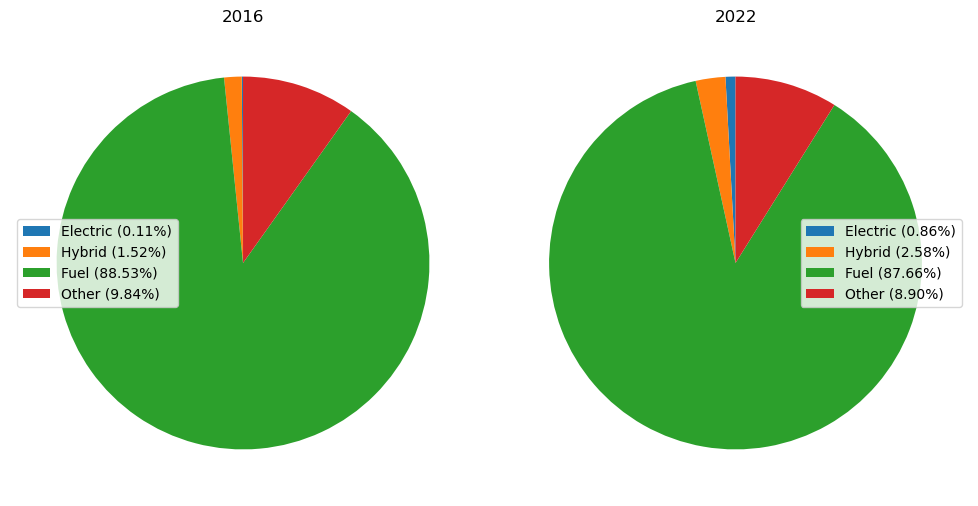

In [429]:
# Vergleich Anteil 2016 zu 2022
registrations_type16 = registrations[registrations['Year'] == 2016]
registrations_type16 = registrations_type16.drop(columns={'Year', 'State'})
registrations_type16 = registrations_type16.sum()

registrations_type22 = registrations[registrations['Year'] == 2022]
registrations_type22 = registrations_type22.drop(columns={'Year', 'State'})
registrations_type22 = registrations_type22.sum()

legend16 = [f'{label} ({value/registrations_type16.sum()*100:.2f}%)' for label, value in zip(registrations_type16.index, registrations_type16)]
legend22 = [f'{label} ({value/registrations_type22.sum()*100:.2f}%)' for label, value in zip(registrations_type22.index, registrations_type22)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pie(registrations_type16, startangle=90)
axs[0].set_title('2016')
axs[0].set_xticks(axs[0].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=8)
axs[0].legend(legend16, loc="center left")

axs[1].pie(registrations_type22, startangle=90)
axs[1].set_title('2022')
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=8)
axs[1].legend(legend22, loc="center right")

plt.tight_layout()
plt.show()

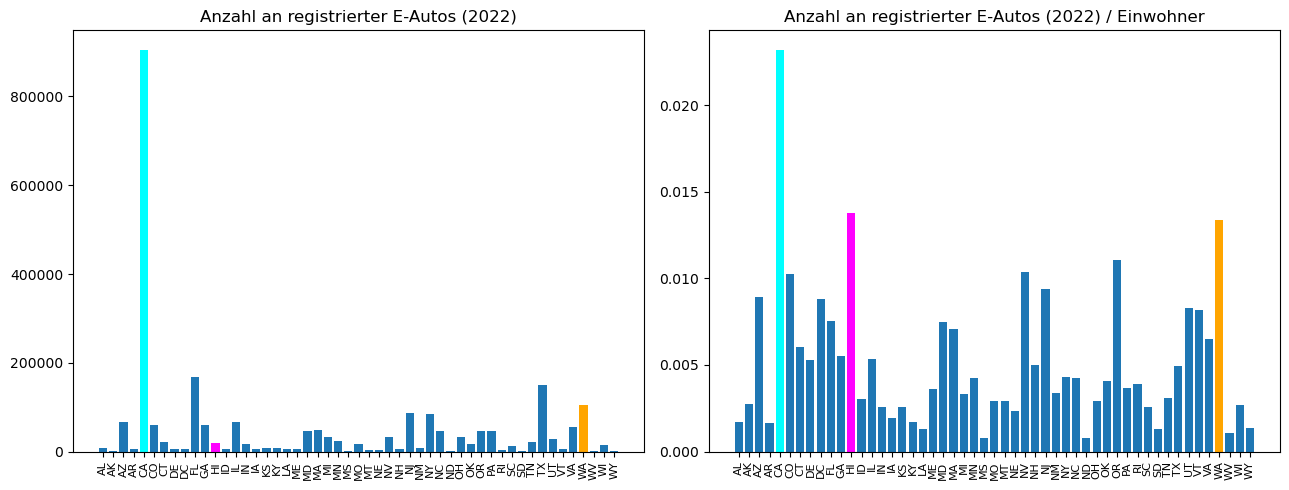

In [430]:
# Anzahl Elektrofahrzeuge je Bundestaat
reg_per_state = registrations[registrations['Year'] == 2022]
reg_per_state = pd.merge(reg_per_state, usa, on='State')

fig, axs = plt.subplots(1, 2, figsize=(13, 5))

axs[0].bar(reg_per_state['Abbreviation'], reg_per_state['Electric'])
axs[0].bar(reg_per_state['Abbreviation'][4], reg_per_state['Electric'][4], color='cyan')
axs[0].bar(reg_per_state['Abbreviation'][11], reg_per_state['Electric'][11], color='magenta')
axs[0].bar(reg_per_state['Abbreviation'][47], reg_per_state['Electric'][47], color='orange')
axs[0].set_title('Anzahl an registrierter E-Autos (2022)')
axs[0].set_xticks(axs[0].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=8)

reg_pop = reg_per_state['Electric'] / reg_per_state['Population']
axs[1].bar(reg_per_state['Abbreviation'], reg_pop)
axs[1].bar(reg_per_state['Abbreviation'][4], reg_pop[4], color='cyan')
axs[1].bar(reg_per_state['Abbreviation'][11], reg_pop[11], color='magenta')
axs[1].bar(reg_per_state['Abbreviation'][47], reg_pop[47], color='orange')
axs[1].set_title('Anzahl an registrierter E-Autos (2022) / Einwohner')
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [431]:
# Wie sind die Ladesäulen in den USA geografisch verteilt
map_center = [stations['Latitude'].mean(), stations['Longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=5)
heat_data = [[row['Latitude'], row['Longitude']] for index, row in stations.iterrows()]
HeatMap(heat_data, radius=10, blur=7).add_to(my_map)
my_map

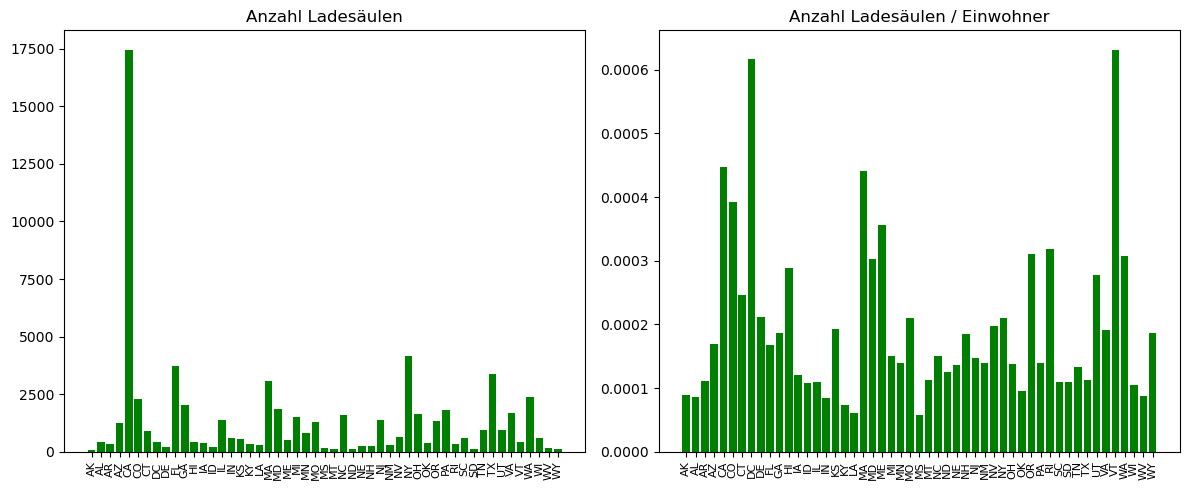

In [432]:
# Welche Bundestaaten haben die höchste bzw. niedrigste Anzahl an Ladesäulen
stations_per_state = stations.groupby('State').size().reset_index(name='Count')
stations_per_state = pd.merge(stations_per_state, usa, left_on='State', right_on='Abbreviation')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(stations_per_state['Abbreviation'], stations_per_state['Count'], color='green')
axs[0].set_title('Anzahl Ladesäulen')
axs[0].set_xticks(axs[0].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=8)

stations_pop = stations_per_state['Count'] / stations_per_state['Population']
axs[1].bar(stations_per_state['Abbreviation'], stations_pop, color='green')
axs[1].set_title('Anzahl Ladesäulen / Einwohner')
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

/var/folders/1n/76f51gz14z3d8jfl34xk49zw0000gn/T/ipykernel_94215/4117929365.py:27: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  s20 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2020, 1, 1)]
/var/folders/1n/76f51gz14z3d8jfl34xk49zw0000gn/T/ipykernel_94215/4117929365.py:28: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  s23 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2023, 1, 1)]


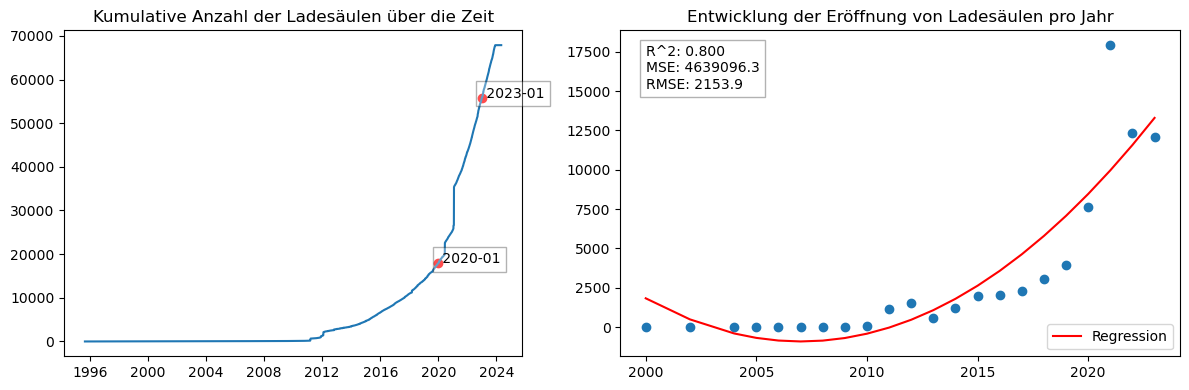

In [433]:
# Wie hat sich die Anzahl der Ladesäulen im Laufe der Zeit entwickelt
# Gibt es einen Trend in der Eröffnung von Ladesäulen über die Jahre?
stations_dev = stations.groupby(stations['Open Date'].dt.date).size().cumsum().reset_index(name='Count')

# erster Tag mit einer Eröffnung im Jahr 2020 bzw. 2023
s20 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2020, 1, 1)]
s23 = stations_dev.loc[stations_dev['Open Date'] >= pd.Timestamp(2023, 1, 1)]

stations_trend = stations.groupby(stations['Open Date'].dt.year).size().reset_index(name='Count')
# erst ab 2000, davor zu gering
# es gibt eine Station 2024 im Datensatz
stations_trend = stations_trend[stations_trend['Open Date'] >= 2000]
stations_trend = stations_trend[stations_trend['Open Date'] != 2024]

x = stations_trend['Open Date']
y = stations_trend['Count']

# Quadratische Regression (Polynomgrad 2)
coefficients = np.polyfit(x, y, 2)

# Erzeugung einer quadratischen Funktion mit den berechneten Koeffizienten
quadratic_function = np.poly1d(coefficients)

# Vorhersage für Werte in x
predicted_y = quadratic_function(x)

r_2 = r2_score(y, predicted_y)
mse = np.mean((y - predicted_y)**2)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [4.5, 5.5]})

axs[0].set_title('Kumulative Anzahl der Ladesäulen über die Zeit')
axs[0].plot(stations_dev['Open Date'], stations_dev['Count'], linestyle='-', label='Linie')
axs[0].scatter([s20.values[0][0], s23.values[0][0]], [s20.values[0][1], s23.values[0][1]], color='red')
axs[0].text(s20.values[0][0], s20.values[0][1], ' 2020-01', bbox=dict(facecolor='white', alpha=0.3))
axs[0].text(s23.values[0][0], s23.values[0][1], ' 2023-01', bbox=dict(facecolor='white', alpha=0.3))

axs[1].set_title('Entwicklung der Eröffnung von Ladesäulen pro Jahr')
axs[1].scatter(x, y)
axs[1].plot(x, predicted_y, label='Regression', color='red')
axs[1].text(min(x), max(y), f'R^2: {r2_score(y, predicted_y):.3f}\nMSE: {mse:.1f}\nRMSE: {np.sqrt(mse):.1f}', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.3))
axs[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

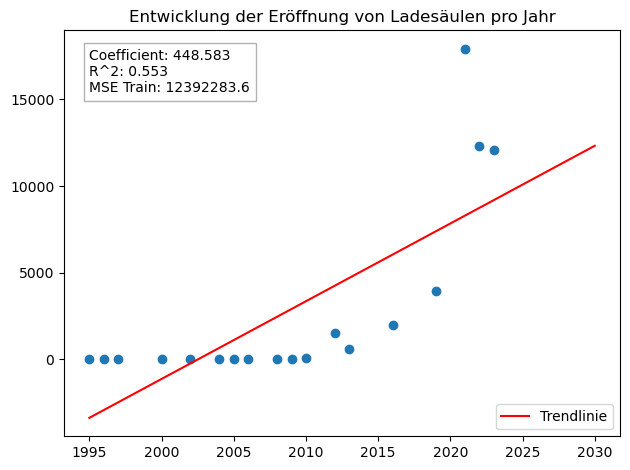

In [434]:
# Entwicklung der Eröffnung pro Jahr - Lineare Regression
stations_trend = stations.groupby(stations['Open Date'].dt.year).size().reset_index(name='Count')
stations_trend = stations_trend[stations_trend['Open Date'] != 2024]

regressor = LinearRegression()
# Input-Variable
x_reg = stations_trend['Open Date']
# Output-Variable
y_reg = stations_trend['Count']

# Aufteilen in Test- und Trainingsdatensatz 
x_reg_train,x_reg_test,y_reg_train,y_reg_test=train_test_split(x_reg,y_reg,test_size=0.3, random_state= 1)

# Lernen des Modells
regressor.fit(np.array(x_reg_train).reshape(-1, 1), np.array(y_reg_train).reshape(-1, 1))

# Plot für Trainingsdaten
x_input = np.linspace(min(x_reg_train), 2030)
y_input = regressor.coef_ * x_input + regressor.intercept_
y_input = y_input.reshape(-1, 1)

# Trainingsfehler R^2 und MSE
y_reg_train_pred = regressor.predict(np.array(x_reg_train).reshape(-1,1))

plt.title('Entwicklung der Eröffnung von Ladesäulen pro Jahr')
plt.scatter(x = x_reg_train, y = y_reg_train)
plt.plot(x_input, y_input, c = 'r', label='Trendlinie')
plt.text(min(x_reg_train), max(y_reg_train), f'Coefficient: {regressor.coef_[0][0]:.3f}\nR^2: {r2_score(y_reg_train, y_reg_train_pred):.3f}\nMSE Train: {mean_squared_error(y_reg_train, y_reg_train_pred):.1f}', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.3))
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

+ Lineare Regression ungeeignet, da kein linearer Zusammenhang vorliegt (siehe R^2 Wert von 0.55)
+ Der MSE Wert von 12 Millionen sagt aus, dass wir eine Durchschnittliche Abweichung von 3520 Ladesäulen zwischen den Datenpunkten und der Trendline haben

---

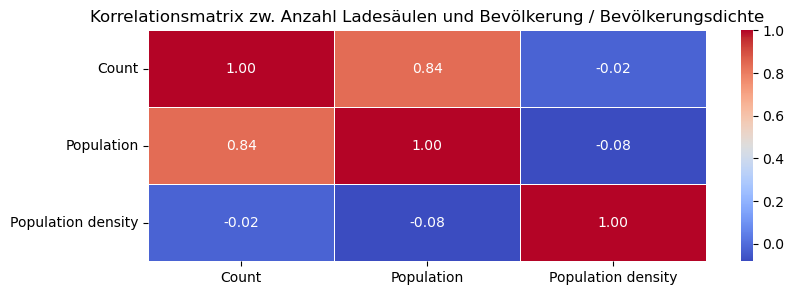

In [435]:
# Korrelation zw. der Anzahl Ladesäulen und anderen Faktoren, wie der Bevölkerung, Bevölkerungsdichte?
stations_corr = stations.groupby(stations['State']).size().reset_index(name='Count')
stations_corr = pd.merge(stations_corr, usa, left_on='State', right_on='Abbreviation')
stations_corr['Population density'] = stations_corr['Population'] / stations_corr['Land_area']

# Korrelationsmatrix erstellen
correlation_matrix = stations_corr[['Count', 'Population', 'Population density']].corr()

# Heatmap der Korrelationsmatrix erstellen
plt.figure(figsize=(9, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korrelationsmatrix zw. Anzahl Ladesäulen und Bevölkerung / Bevölkerungsdichte')
plt.yticks(rotation=0)
plt.show()

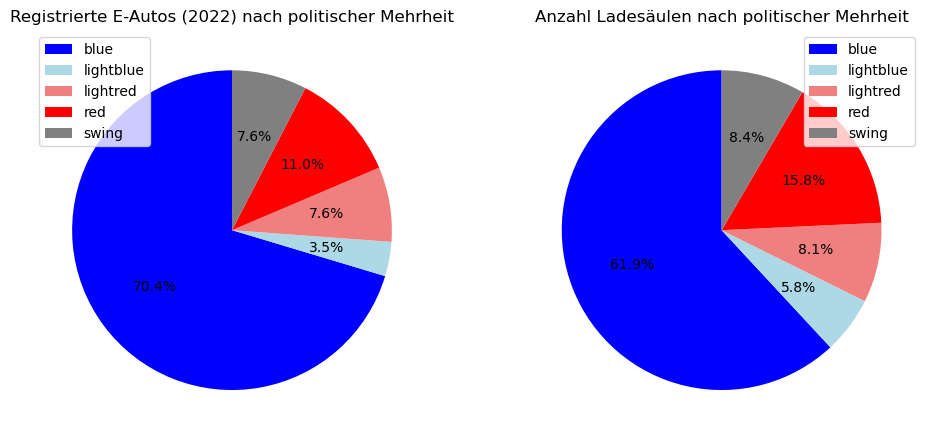

In [436]:
# registrations / plolitischer Mehrheit - stations / politischer Mehrheit 
reg_vote = registrations[registrations['Year'] == 2022]
reg_vote = pd.merge(registrations, usa, on='State')
reg_vote = reg_vote.groupby('Vote')['Electric'].sum().reset_index(name='Count')

stations_vote = pd.merge(stations, usa, left_on='State', right_on='Abbreviation')
stations_vote = stations_vote.groupby('Vote').size().reset_index(name='Count')

fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

axs[0].pie(reg_vote['Count'], autopct='%1.1f%%', startangle=90, colors=['blue', 'lightblue', 'lightcoral', 'red', 'grey'])
axs[0].set_title('Registrierte E-Autos (2022) nach politischer Mehrheit')
axs[0].set_xticks(axs[0].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=8)
axs[0].legend(stations_vote['Vote'], loc="upper left")

axs[1].pie(stations_vote['Count'], autopct='%1.1f%%', startangle=90, colors=['blue', 'lightblue', 'lightcoral', 'red', 'grey'])
axs[1].set_title('Anzahl Ladesäulen nach politischer Mehrheit')
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=8)
axs[1].legend(stations_vote['Vote'], loc="upper right")

plt.tight_layout()
plt.show()

+ blue = 4/4 der letzten Wahlen demokratisch
+ light blue = 3/4 der letzten Wahlen demokratisch
+ light red = 3/4 der letzten Wahlen republikanisch
+ red = 4/4 der letzten Wahlen republikanisch
+ swing = jeweils 2